In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns

# initialize tqdm
tqdm.pandas()

In [6]:
# Define function to load and preprocess BBC data
def load_and_preprocess_the_BBC_data(file_path):
    """Load BBC news data and prepare it for concatenation."""
    df = pd.read_csv(file_path, low_memory=False) 
    df["type"] = 0
    df = df.dropna(subset=["content"])
    # Return only necessary columns
    return df[["content", "type"]]

bbc_df = load_and_preprocess_the_BBC_data("data/bbc_articles_cleaned.csv")

In [7]:
# Only remove unreliable labels
df = pd.read_csv('data/995,000_row_cleaned.csv')

# Remove rows with ivalid values
label_map = {"fake": 1, "satire":1, "conspiracy": 1, "bias": 1, "rumor": 1, "junksci": 1, "hate": 1,  "clickbait": 1,   "political": 1,
             "reliable": 0}
df = df[df["type"].isin(label_map.keys())]  # Keep only rows with valid labels
print(df["type"].value_counts())
df["type"] = df["type"].map(label_map)
print(df["type"].value_counts())

# Seperate data into training, validation, and test sets
y = pd.concat([pd.Series(df["type"]), pd.Series(bbc_df["type"])], ignore_index=True)
X = pd.concat([pd.Series(df["content"]), pd.Series(bbc_df["content"])], ignore_index=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Transform the data with Bag of Words
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)  
X_val = vectorizer.transform(X_val)          
X_test = vectorizer.transform(X_test)  
dump(vectorizer, 'models/BBCBoWvectorizer.joblib')

# Train the model
model = LogisticRegression(max_iter=1000, verbose=1)
model = model.fit(X_train, y_train)
# Save the model
dump(model, 'models/BBClogistic_regression_classifier.joblib')



/var/folders/z1/hf1tn63x7tl1qjxy1md9xy4w0000gn/T/ipykernel_17627/708885610.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/995,000_row_cleaned.csv')


type
reliable      218564
political     194518
bias          133232
fake          104883
conspiracy     97314
rumor          56445
clickbait      27412
junksci        14040
satire         13160
hate            8779
Name: count, dtype: int64
type
1    649783
0    218564
Name: count, dtype: int64


['models/logistic_regression_classifier.joblib']

In [8]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))

    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    plt.title('Confusion Matrix')
    sns.set_theme(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    

LogisticRegression MSE:  0.06368092794181952
LogisticRegression accuracy:  0.9363190720581804
LogisticRegression F1 score:  0.9572809238559872


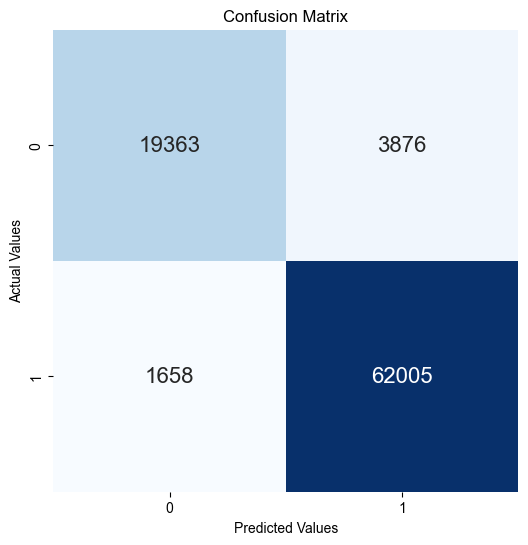

In [9]:
# Evaluate the model
y_pred = model.predict(X_val)
mse = ((y_val-y_pred)**2).mean()

print("LogisticRegression MSE: ", mse)
print("LogisticRegression accuracy: ", accuracy_score(y_val, y_pred))
print("LogisticRegression F1 score: ", f1_score(y_val, y_pred))
conf_matrix(y_val, y_pred)